 # CLASSIFICATION MODEL

### Prepare Library, Parameters, and Dependencies

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import cv2
import itertools
import pathlib
import os

%matplotlib inline

In [2]:
# UNCOMMENT THIS IF YOU USE GOOGLE COLAB

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Check TensorFlow Version and GPU Availability
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.14.0
Num GPUs Available:  1


In [4]:
# Set Parameters
DATASET_DIR = "/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/classification_datasets/roboflow_cataract_segmented/"
TEST_PREDICT_DIR = "/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/"
SAVE_MODEL_PATH = '/content/drive/MyDrive/Skripsi/v_0.0.2/models/classification_model_2/'

BATCH_SIZE = 8
VAL_RATIO = 0.3
SHUFFLE_BUFFER_SIZE = 1100

IMG_HEIGHT = 128
IMG_WIDTH = 128

SHUFFLE_VALUE = True
AUTOTUNE = tf.data.AUTOTUNE

### Load & Split Dataset

In [5]:
# Make Train Dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=VAL_RATIO,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE,
)

# Make Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=VAL_RATIO,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE,
)

# Make Test Dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 3)
val_ds = val_ds.skip(val_batches // 3)

# Print Dataset Information
print(f'Number of training batches: {len(np.concatenate([i for x, i in train_ds]))}')
print(f'Number of validation batches: {len(np.concatenate([i for x, i in val_ds]))}')
print(f'Number of test batches: {len(np.concatenate([i for x, i in test_ds]))}')

Found 594 files belonging to 3 classes.
Using 416 files for training.
Found 594 files belonging to 3 classes.
Using 178 files for validation.
Number of training batches: 416
Number of validation batches: 122
Number of test batches: 56


['immature', 'mature', 'normal']


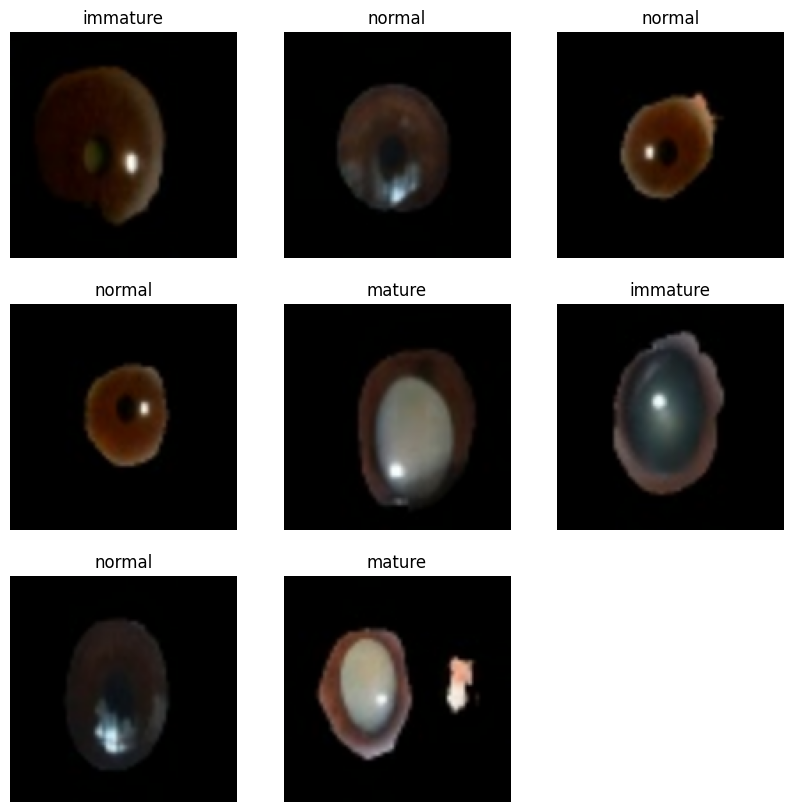

In [6]:
# Return Class Names from Dataset
class_names = train_ds.class_names
print(class_names)

# Visualize Classification Dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Data Augmentation & Preparation

In [7]:
# Augmentation Sequential
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip(mode='horizontal'),
    keras.layers.RandomRotation(factor=0.4),
    keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
])

### Dataset Pipelining

In [8]:
train_ds = train_ds.cache().shuffle(SHUFFLE_BUFFER_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Callbacks

In [24]:
class myCallback(keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_loss') is not None and logs.get('val_loss') < 0.25 and logs.get('accuracy') is not None and logs.get('accuracy') > 0.9:
                print("\nReached 0.25 val_loss so cancelling training!")

                # Stop training once the above condition is met
                self.model.stop_training = True

stop_callback = myCallback()

### Model Architecture #1 (CNN Vanilla)

In [25]:
# Build Model
model = tf.keras.Sequential([
    keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    data_augmentation,
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(class_names))
])

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)      

### Train Model #1

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
    # callbacks=[myCallback()]
)

Epoch 1/50
52/52 [==============================] - 4s 18ms/step - loss: 1.5467 - accuracy: 0.4736 - val_loss: 0.8181 - val_accuracy: 0.5820
Epoch 2/50
52/52 [==============================] - 1s 12ms/step - loss: 0.9900 - accuracy: 0.5745 - val_loss: 0.8451 - val_accuracy: 0.6066
Epoch 3/50
52/52 [==============================] - 1s 12ms/step - loss: 0.7637 - accuracy: 0.6659 - val_loss: 0.6761 - val_accuracy: 0.6475
Epoch 4/50
52/52 [==============================] - 1s 12ms/step - loss: 0.6957 - accuracy: 0.7043 - val_loss: 0.6177 - val_accuracy: 0.6967
Epoch 5/50
52/52 [==============================] - 1s 12ms/step - loss: 0.6419 - accuracy: 0.7091 - val_loss: 0.4804 - val_accuracy: 0.8115
Epoch 6/50
52/52 [==============================] - 1s 12ms/step - loss: 0.5624 - accuracy: 0.7620 - val_loss: 0.5506 - val_accuracy: 0.7787
Epoch 7/50
52/52 [==============================] - 1s 12ms/step - loss: 0.4827 - accuracy: 0.7861 - val_loss: 0.4167 - val_accuracy: 0.7869
Epoch 8/50
52

### Evaluate Model With Test Dataset

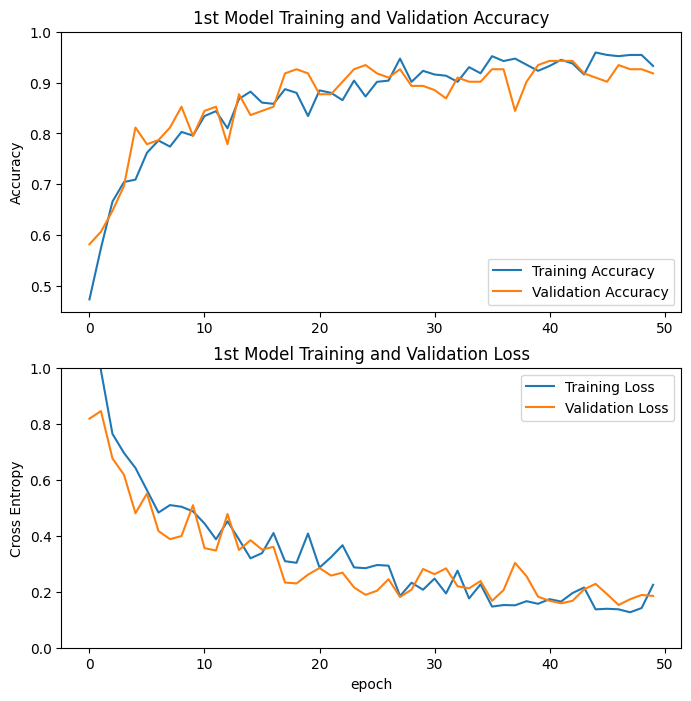

In [29]:
# Retrieve Accuracy and Loss from Classification Model
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('1st Model Training and Validation Accuracy')

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('1st Model Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
# Evaluate Model
loss, accuracy = model.evaluate(test_ds)

7/7 [==============================] - 0s 5ms/step - loss: 0.2605 - accuracy: 0.9464


In [31]:
# Retrieve a True Label from the Test Dataset
y_true = np.concatenate([i for x, i in test_ds])

# Make Prediction
y_pred = np.argmax(model.predict(test_ds), axis=-1)

# Plot Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

7/7 [==============================] - 0s 3ms/step


In [32]:
# Plot Function Confusion Matrix
def show_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=15)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

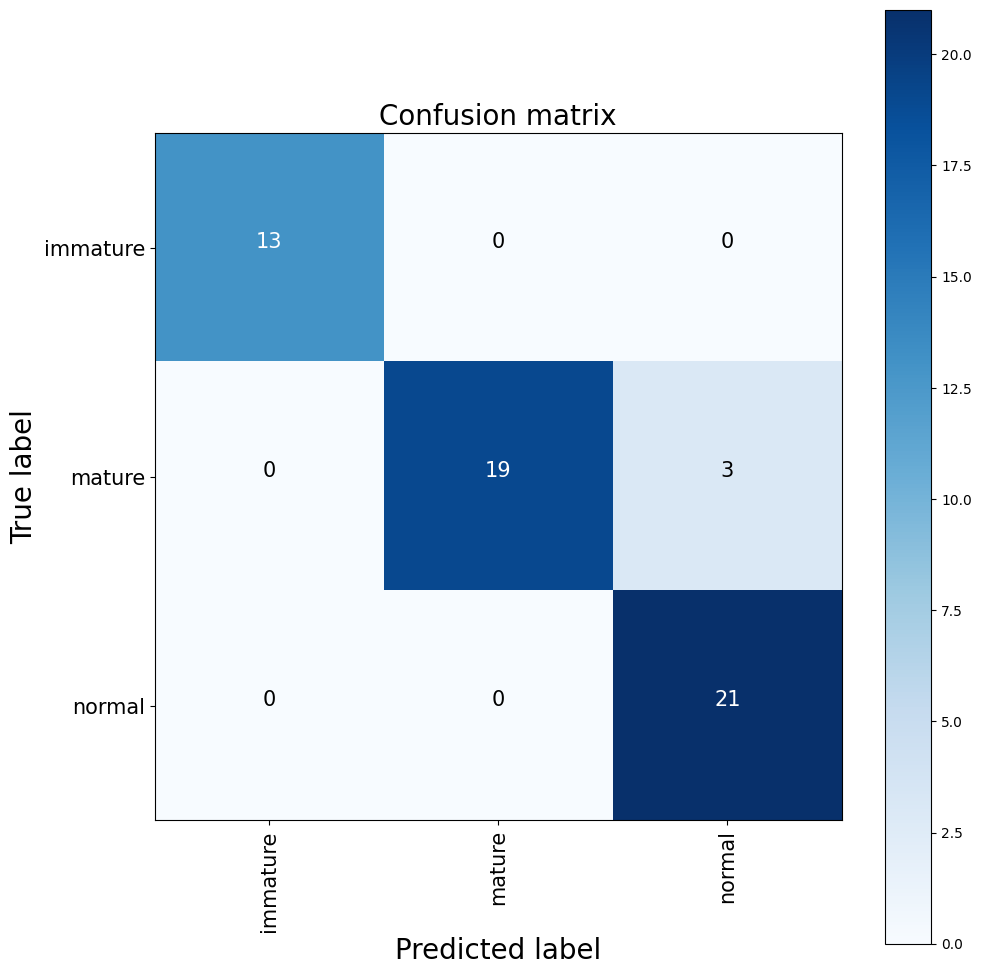

In [33]:
show_confusion_matrix(conf_mat, class_names)

### Test With Cataract Dataset

In [34]:
# Predict Sequential
predict_model = keras.Sequential([
    model,
    keras.layers.Softmax()
])

In [35]:
# Predict with Real Cataract Image
for filename in os.listdir(TEST_PREDICT_DIR):
    img = keras.preprocessing.image.load_img(TEST_PREDICT_DIR + filename, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = predict_model.predict(img_array)

    score = tf.nn.softmax(predictions[0])

    print(filename)
    print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
    print(predictions)

1/1 [==============================] - 0s 109ms/step
katarak-matur3.jpg
This image most likely belongs to mature with a 55.59 percent confidence.
[[0.05373866 0.9452548  0.0010065 ]]
1/1 [==============================] - 0s 20ms/step
katarak_matur1.jpg
This image most likely belongs to immature with a 41.63 percent confidence.
[[0.5833744  0.4094754  0.00715028]]
1/1 [==============================] - 0s 18ms/step
katarak_matur2.png
This image most likely belongs to mature with a 57.57 percent confidence.
[[7.6916302e-04 9.9876463e-01 4.6619936e-04]]


### Save Model with TensorFlow Lite Converter

In [23]:
# Export Model to SavedModel Format
tf.saved_model.save(model, SAVE_MODEL_PATH)

# Convert SavedModel to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model(SAVE_MODEL_PATH)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the Model
tflite_model_file = pathlib.Path(SAVE_MODEL_PATH + 'model.tflite')
tflite_model_file.write_bytes(tflite_model)

9294872